<h2> Sorel Data Preprocessing To get the Features </h2>

In [23]:
import tqdm
import lmdb
import json
import numpy as np
import pandas as pd
import sqlite3
import os
import msgpack
import zlib
import tqdm
import pandas as pd
import seaborn as sns
from tabulate import tabulate

<h4> Make sure 'data.mdb' and   'lock.mdb' files present in sorel_lmdb </h4>
<h4> Refer this https://github.com/sophos-ai/SOREL-20M to Download these files</h4>
<h5> 'meta.db' 3.5GB file will be present in s3://sorel-20m/09-DEC-2020/processed-data </h5>
<h5> 'data.mdb' and   'lock.mdb' will be present in s3://sorel-20m/09-DEC-2020/processed-data/ember_features with size approx  ~72GB </h5>

In [2]:
sorel_dir = '../Dataset/sorel'
sorel_lmdb = '../Dataset/sorel/db'
sorel_db = '../Dataset/sorel/meta.db'
!ls '../Dataset/sorel/db'

data.mdb  lock.mdb


<h5> Reading malware_information from db and saving it to  'sorel_malware.csv' </h5>
<h5> If  'sorel_malware.csv' not exist run this below code </h5>


In [4]:
# con = sqlite3.connect(sorel_db)
# df = pd.read_sql_query("SELECT * from meta where is_malware=1", con)
# df.to_csv(os.path.join(sorel_dir,'sorel_malware.csv'))


<h5> Load the Data from 'sorel_malware.csv'</h5>

In [24]:
df = pd.read_csv(os.path.join(sorel_dir,'sorel_malware.csv'))


In [25]:
df.columns


Index(['Unnamed: 0', 'sha256', 'is_malware', 'rl_fs_t',
       'rl_ls_const_positives', 'adware', 'flooder', 'ransomware', 'dropper',
       'spyware', 'packed', 'crypto_miner', 'file_infector', 'installer',
       'worm', 'downloader'],
      dtype='object')

<h4> The current datset contains 11 different classes of malware </h4>

In [26]:
labels = ['adware', 'flooder', 'ransomware', 'dropper',
       'spyware', 'packed', 'crypto_miner', 'file_infector', 'installer',
       'worm', 'downloader']

<h5> Added two extra columns sum and label. Divided the counts of each class with sum to get the probability 
of each class and label represents the class with max probability</h5>

In [27]:
df['sum'] =df.iloc[:,5:16 ].sum(axis=1)
for label in labels:
    df[label]= df[label]/df['sum']


In [28]:
df['label']= np.argmax(df.values[:,5:16],axis=1)

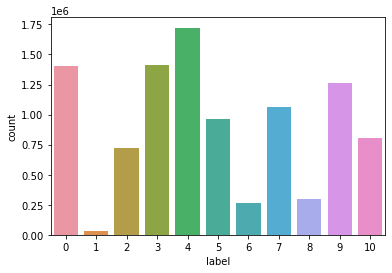

In [29]:
data = pd.DataFrame(data=df['label'], columns=["label"])
sns.countplot(x = 'label', data=data);

In [30]:
values,counts = np.unique(df['label'].values,return_counts=True)
table = []
for i,j in zip(labels,counts):
    table.append([i,str(j)])
print (tabulate(table,headers=['label', 'sample_count']))

label            sample_count
-------------  --------------
adware                1404601
flooder                 27896
ransomware             721508
dropper               1414233
spyware               1722713
packed                 964299
crypto_miner           268673
file_infector         1063928
installer              300247
worm                  1265735
downloader             808987


<h5> selected samples with detection sum > 15 and 7000 samples from each class </h5>

In [31]:
 df2 = df[df['sum']>14].groupby('label').head(10000).reset_index(drop=True)

In [32]:
df2.iloc[:,5:18][:10]

,adware,flooder,ransomware,dropper,spyware,packed,crypto_miner,file_infector,installer,worm,downloader,sum,label
0,0.000000,0.0,0.0,0.0,0.5,0.0,0.0,0.5,0.000000,0.0,0.000000,18,4
1,0.388889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.611111,0.0,0.000000,18,8
2,0.388889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.611111,0.0,0.000000,18,8
3,0.388889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.611111,0.0,0.000000,18,8
4,0.368421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.631579,0.0,0.000000,19,8
5,0.533333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.466667,0.0,0.000000,15,0
6,0.578947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.421053,0.0,0.000000,19,0
7,0.437500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.562500,0.0,0.000000,16,8
8,0.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.533333,0.0,0.066667,15,8
9,0.368421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.631579,0.0,0.000000,19,8


In [33]:
df2.shape

(109481, 18)

<h5> Saving the selected samples with prob.scores and label to sorel_label.csv for future use </h5>

In [18]:
df2.to_csv(os.path.join(sorel_dir,'sorel_label.csv'))


<h5> Load sample data from  sorel_label.csv </h5>

In [19]:
df2 = pd.read_csv(os.path.join(sorel_dir,'sorel_label.csv')).iloc[:,1:]

In [12]:
df2.shape

(109481, 18)

In [25]:
df2.values[np.where(df2.values[:,-1]==1)]

(9481, 18)

<h5> Get featutes Corressponds to each sample from lmdb database using sha256 Key </h5>
<h5> and save feature in data array and coresponding labels in y array </h5>
<h5> Some entry feature may not present in the db, igonre these samples </h5>

In [26]:
env = lmdb.Environment(sorel_lmdb, readonly=True, map_size=1e13, max_readers=1024)

x =None
D = None
count = 0
with env.begin(write=False) as txn:
    for d in tqdm.tqdm((df2.values[np.where(df2.values[:,-1]==1)])):
        x = txn.get(d[1].encode('ascii'))
        if x:
            count = count+1
            x = msgpack.loads(zlib.decompress(x),strict_map_key=False)
            data = np.append(data,np.array([x[0]]),axis=0)
            y = np.append(y,np.array([d[5:]]),axis=0)

            
        if count%1000==0:
            np.savez(os.path.join(sorel_dir,'sorel_data.npz'), data, y)
np.savez(os.path.join(sorel_dir,'sorel_data.npz'), data, y)

100%|██████████| 9481/9481 [07:34<00:00, 20.85it/s]


In [27]:
env = lmdb.Environment(sorel_lmdb, readonly=True, map_size=1e13, max_readers=1024)

x =None
D = None
count = 0
with env.begin(write=False) as txn:
    for d in tqdm.tqdm((df2.values[np.where(df2.values[:,-1]==3)])):
        x = txn.get(d[1].encode('ascii'))
        if x:
            count = count+1
            x = msgpack.loads(zlib.decompress(x),strict_map_key=False)
            data = np.append(data,np.array([x[0]]),axis=0)
            y = np.append(y,np.array([d[5:]]),axis=0)

            
        if count%1000==0:
            np.savez(os.path.join(sorel_dir,'sorel_data.npz'), data, y)
np.savez(os.path.join(sorel_dir,'sorel_data.npz'), data, y)

100%|██████████| 10000/10000 [19:09<00:00,  8.70it/s]


In [28]:

env = lmdb.Environment(sorel_lmdb, readonly=True, map_size=1e13, max_readers=1024)

x =None
D = None
count = 0
with env.begin(write=False) as txn:
    for d in tqdm.tqdm((df2.values[np.where(df2.values[:,-1]==6)])):
        x = txn.get(d[1].encode('ascii'))b
        if x:
            count = count+1
            x = msgpack.loads(zlib.decompress(x),strict_map_key=False)
            data = np.append(data,np.array([x[0]]),axis=0)
            y = np.append(y,np.array([d[5:]]),axis=0)

            
        if count%1000==0:
            np.savez(os.path.join(sorel_dir,'sorel_data.npz'), data, y)
np.savez(os.path.join(sorel_dir,'sorel_data.npz'), data, y)

100%|██████████| 10000/10000 [31:25<00:00,  5.30it/s] 


In [34]:
npzfile = np.load(os.path.join(sorel_dir,'sorel_data.npz'),allow_pickle=True)
data,y = npzfile['arr_0'],npzfile['arr_1']
data.shape

(91746, 2381)

In [35]:
df22 = df2.values[np.where(df2.values[:,-1]!=1)]
df22 = df22[np.where(df22[:,-1]!=3)]
df22 = df22[np.where(df22[:,-1]!=6)]
df22 = df22[np.where(df22[:,-1]!=7)]
df22 = df22[np.where(df22[:,-1]!=8)]
df22 = df22[np.where(df22[:,-1]!=9)]
df22 = df22[np.where(df22[:,-1]!=10)]
df22.shape
np.unique(df22[:,-1],return_counts=True)

(array([0, 2, 4, 5], dtype=object), array([10000, 10000, 10000, 10000]))

In [ ]:

env = lmdb.Environment(sorel_lmdb, readonly=True, map_size=1e13, max_readers=1024)

x =None
D = None
count = 0
with env.begin(write=False) as txn:
    for d in tqdm.tqdm(df22[24000:]):
        x = txn.get(d[1].encode('ascii'))
        if x:
            count = count+1
            x = msgpack.loads(zlib.decompress(x),strict_map_key=False)
            data = np.append(data,np.array([x[0]]),axis=0)
            y = np.append(y,np.array([d[5:]]),axis=0)


        if count%1000==0:
            np.savez(os.path.join(sorel_dir,'sorel_data.npz'), data, y)
np.savez(os.path.join(sorel_dir,'sorel_data.npz'), data, y)

 83%|████████▎ | 13229/16000 [3:16:04<51:54,  1.12s/it]  

In [ ]:
npzfile = np.load(os.path.join(sorel_dir,'sorel_data.npz'),allow_pickle=True)
data,y = npzfile['arr_0'],npzfile['arr_1']
arr = [4,5]
for val in arr:
    env = lmdb.Environment(sorel_lmdb, readonly=True, map_size=1e13, max_readers=1024)

    x =None
    D = None
    count = 0
    with env.begin(write=False) as txn:
        for d in tqdm.tqdm((df2.values[np.where(df2.values[:,-1]==val)])):
            x = txn.get(d[1].encode('ascii'))
            if x:
                count = count+1
                x = msgpack.loads(zlib.decompress(x),strict_map_key=False)
                data = np.append(data,np.array([x[0]]),axis=0)
                y = np.append(y,np.array([d[5:]]),axis=0)


            if count%1000==0:
                np.savez(os.path.join(sorel_dir,'sorel_data.npz'), data, y)
    np.savez(os.path.join(sorel_dir,'sorel_data.npz'), data, y)

In [ ]:
npzfile = np.load(os.path.join(sorel_dir,'sorel_data.npz'),allow_pickle=True)
data,y = npzfile['arr_0'],npzfile['arr_1']
arr = [7,8]
for val in arr:
    env = lmdb.Environment(sorel_lmdb, readonly=True, map_size=1e13, max_readers=1024)

    x =None
    D = None
    count = 0
    with env.begin(write=False) as txn:
        for d in tqdm.tqdm((df2.values[np.where(df2.values[:,-1]==val)])):
            x = txn.get(d[1].encode('ascii'))
            if x:
                count = count+1
                x = msgpack.loads(zlib.decompress(x),strict_map_key=False)
                data = np.append(data,np.array([x[0]]),axis=0)
                y = np.append(y,np.array([d[5:]]),axis=0)


            if count%1000==0:
                np.savez(os.path.join(sorel_dir,'sorel_data.npz'), data, y)
    np.savez(os.path.join(sorel_dir,'sorel_data.npz'), data, y)

In [ ]:
npzfile = np.load(os.path.join(sorel_dir,'sorel_data.npz'),allow_pickle=True)
data,y = npzfile['arr_0'],npzfile['arr_1']
arr = [9,10]
for val in arr:
    env = lmdb.Environment(sorel_lmdb, readonly=True, map_size=1e13, max_readers=1024)

    x =None
    D = None
    count = 0
    with env.begin(write=False) as txn:
        for d in tqdm.tqdm((df2.values[np.where(df2.values[:,-1]==val)])):
            x = txn.get(d[1].encode('ascii'))
            if x:
                count = count+1
                x = msgpack.loads(zlib.decompress(x),strict_map_key=False)
                data = np.append(data,np.array([x[0]]),axis=0)
                y = np.append(y,np.array([d[5:]]),axis=0)


            if count%1000==0:
                np.savez(os.path.join(sorel_dir,'sorel_data.npz'), data, y)
    np.savez(os.path.join(sorel_dir,'sorel_data.npz'), data, y)

In [ ]:
arr = [7,8,9,10]
for val in arr:
    env = lmdb.Environment(sorel_lmdb, readonly=True, map_size=1e13, max_readers=1024)

    x =None
    D = None
    count = 0
    with env.begin(write=False) as txn:
        for d in tqdm.tqdm((df2.values[np.where(df2.values[:,-1]==val)])):
            x = txn.get(d[1].encode('ascii'))
            if x:
                count = count+1
                x = msgpack.loads(zlib.decompress(x),strict_map_key=False)
                data = np.append(data,np.array([x[0]]),axis=0)
                y = np.append(y,np.array([d[5:]]),axis=0)


            if count%1000==0:
                np.savez(os.path.join(sorel_dir,'sorel_data.npz'), data, y)
    np.savez(os.path.join(sorel_dir,'sorel_data.npz'), data, y)

<h5> It is taking almost a day to finish the task</h5>
<h5>stopped early and got features of 54511 samples and saved them in 'sorel_data.npz' for future use</h5>

In [23]:
npzfile = np.load(os.path.join(sorel_dir,'sorel_data.npz'),allow_pickle=True)
data,y = npzfile['arr_0'],npzfile['arr_1']

In [24]:
npzfile['arr_1'].shape

(54511, 13)

In [25]:
data,y = npzfile['arr_0'],npzfile['arr_1']

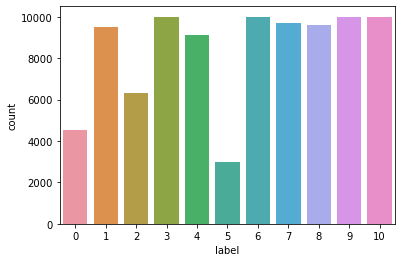

In [36]:
data_labels = pd.DataFrame(data=y[:,-1], columns=["label"])
sns.countplot(x = 'label', data=data_labels);

In [17]:
data.shape

(58466, 2381)